In [42]:
library(corrplot)
library(stringr)
library(RColorBrewer)

corrplot 0.84 loaded


# Color pallettes

In [2]:
liver_celltypes_human <- data.frame(celltypes = c("abT_cell", "central_venous_sinusoidal_endothelial_cells", "Cholangiocytes", "gdT_cell", "Hepatic_Stellate_Cells",
                                                  "Hepatocytes0", "Hepatocytes1", "Hepatocytes3", "Hepatocytes4", "inflammatory_macrophages", "Kupffer_cell", "Mature_B_cells",
                                                  "NK.NKT_cell", "Periportal_sinusoidal_endothelial_cells", "Plasma_cell"),
                                   colors     = c("#db4e00", "#00c2c0", "#0a9d06", "#fa9c00", "#9ed242", "#b53bc7", "#641f52", "#f1a8f2", "#ff4bcc", "#cdad02",
                                                 "#f0d710", "#f77841", "#ff8e77", "#0075da", "#a00621"))

liver_celltypes_mouse <- data.frame(celltypes = c("B_cell", "endothelial_cell_of_hepatic_sinusoid", "hepatocyte", "Kupffer_cell", "natural_killer_cell"),
                                   colors  = c("#f77841", "#00c2c0", "#b53bc7", "#f0d710", "#ff8e77"))

# Data and order

In [3]:
gtex_samples   = read.table("/publicdata/gtex_v7/GTEx_v7_Annotations_SampleAttributesDS_V2.txt", header = TRUE, sep = "\t")

gtex_samples_atrium = gtex_samples[gtex_samples$SMTSD == "Heart - Atrial Appendage", "SAMPID"]


In [4]:
liver_mouse = read.csv("../tables/Cibersort_out/CIBERSORT.Output_Job78_liver_mouse.csv")
liver_human = read.csv("../tables/Cibersort_out/CIBERSORT.Output_Job79_liver_human.csv")

In [6]:
liver_order = liver_human[order(-liver_human$Hepatocytes0, -liver_human$Hepatocytes3, -liver_human$Hepatocytes4), "Input.Sample"]

# Bar plot

In [7]:
figure_width  =  7
figure_height = 5
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

In [8]:
CiberBarFrazer <- function(ciber, colors, main0, ordered, legy){
    
    rownames(ciber) <- ciber$Input.Sample
    ciber$Input.Sample <- NULL
    ciber = ciber[, seq(1, (ncol(ciber) - 3))]
    ciber = ciber[ordered,]
    nsamples = nrow(ciber)
    ciber = as.data.frame(t(ciber) * 100)

    ciber$color = colors[ match(colors$celltypes, rownames(ciber)),  "colors"]
    
    barplot(as.matrix(ciber[, seq(1, (ncol(ciber) - 1))]), las = 2, col = ciber$color, border=NA, names.arg = rep("", ncol(ciber) - 1), 
           ylab = "Fraction clusters", main = main0)

    text(nsamples * .05, legy + 3, paste("n = ", nsamples, sep = ""), pos = 4)

    legend(nsamples * .05, legy, gsub("_", " ", colors$celltypes), bty = "n",
           pch = rep(22, nrow(colors)),
           pt.cex = rep(1.5, nrow(colors)),
           pt.bg = colors$colors )
    
}

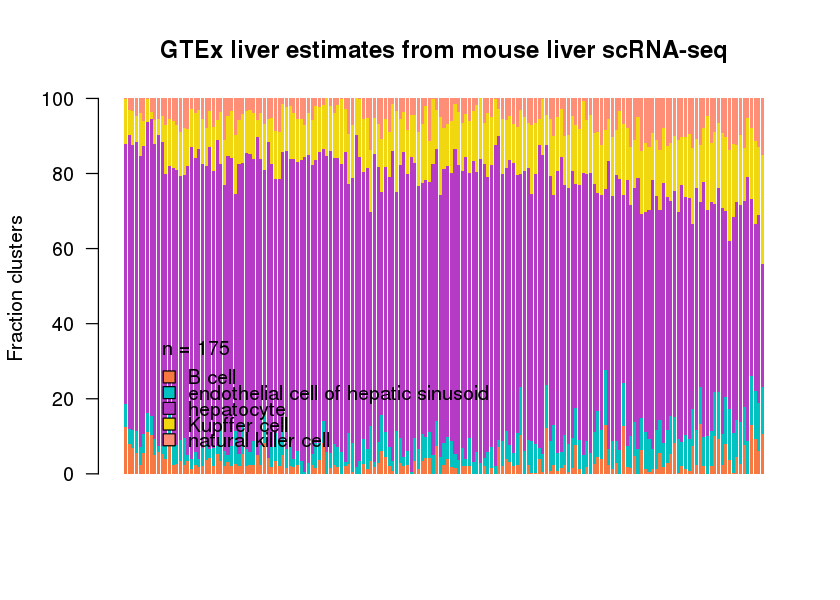

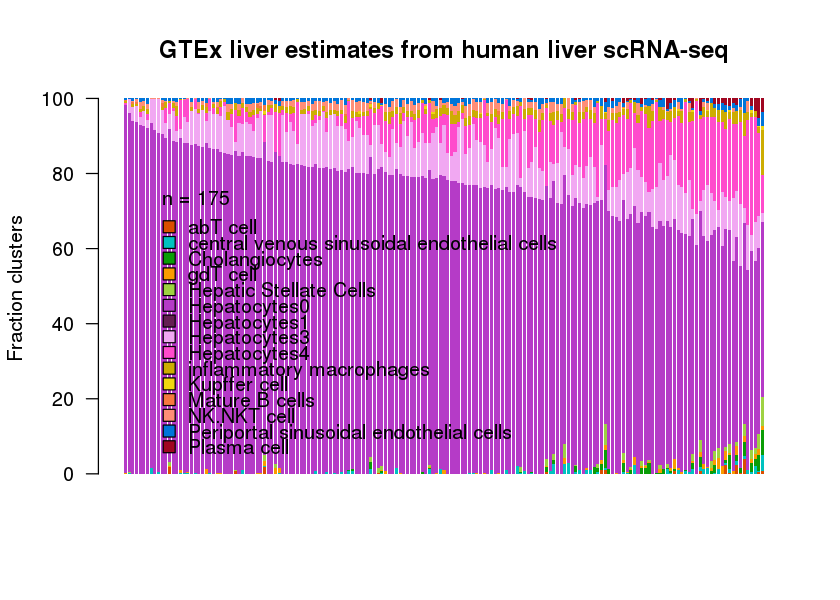

In [9]:
CiberBarFrazer(liver_mouse, liver_celltypes_mouse, "GTEx liver estimates from mouse liver scRNA-seq", liver_order, 30)
CiberBarFrazer(liver_human, liver_celltypes_human, "GTEx liver estimates from human liver scRNA-seq", liver_order, 70)

## Liver collapsed

In [10]:
figure_width  =  7
figure_height = 5
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

In [11]:
liver_celltypes_collapsed <- data.frame(celltypes = c("merged_Hepatocyte",
                                                      "merged_Endothelial",
                                                      "merged_Macrophage",
                                                      "merged_B_cell",
                                                      "merged_NK.NKT_cell",
                                                      "merged_Cholangiocyte",
                                                      "merged_Heptatic_stellate_cell"),
                                   colors  = c("#b53bc7", "#00c2c0", "#f0d710", "#f77841", "#ff8e77", "#0a9d06", "#9ed242"))

In [12]:
library(stringr)

In [13]:
collapse = read.table("../tables/merged_human_liver_cibersort.txt", header = T)

In [14]:
collapse$fakecol1 <- NA
collapse$fakecol2 <- NA
collapse$fakecol3 <- NA

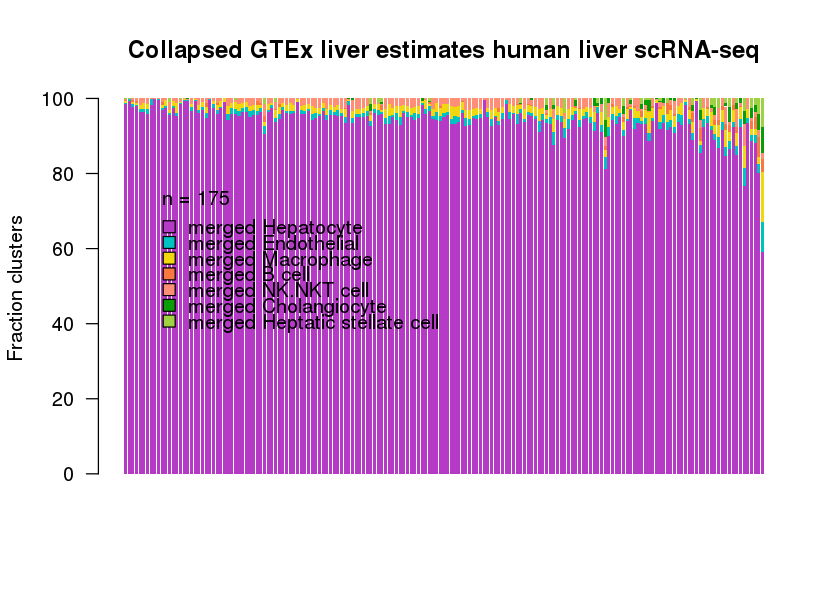

In [15]:
CiberBarFrazer(collapse, liver_celltypes_collapsed, "Collapsed GTEx liver estimates human liver scRNA-seq", liver_order, 70)

# Correlation plot

In [17]:
liver_human$endothelial <- liver_mouse$endothelial_cell_of_hepatic_sinusoid + liver_human$Periportal_sinusoidal_endothelial_cells

In [40]:
CorrPlotFrazer <- function(x, y, xmax, main){
    
    plot(x, y, xlim = c(0, xmax), ylim = c(0,xmax), las = 1, pch = 20, cex = 1.5, main = main, xlab = "Estimate from human", ylab = "Estimate from mouse")
    
    text(xmax*.1, xmax,   round(cor(x, y), 2)) 
    text(xmax*.1, xmax*.95, signif(cor.test(x, y)$p.value, 3)) 
    
    lines(c(-0.1, 1.1), c(-0.1, 1.1))
    
}

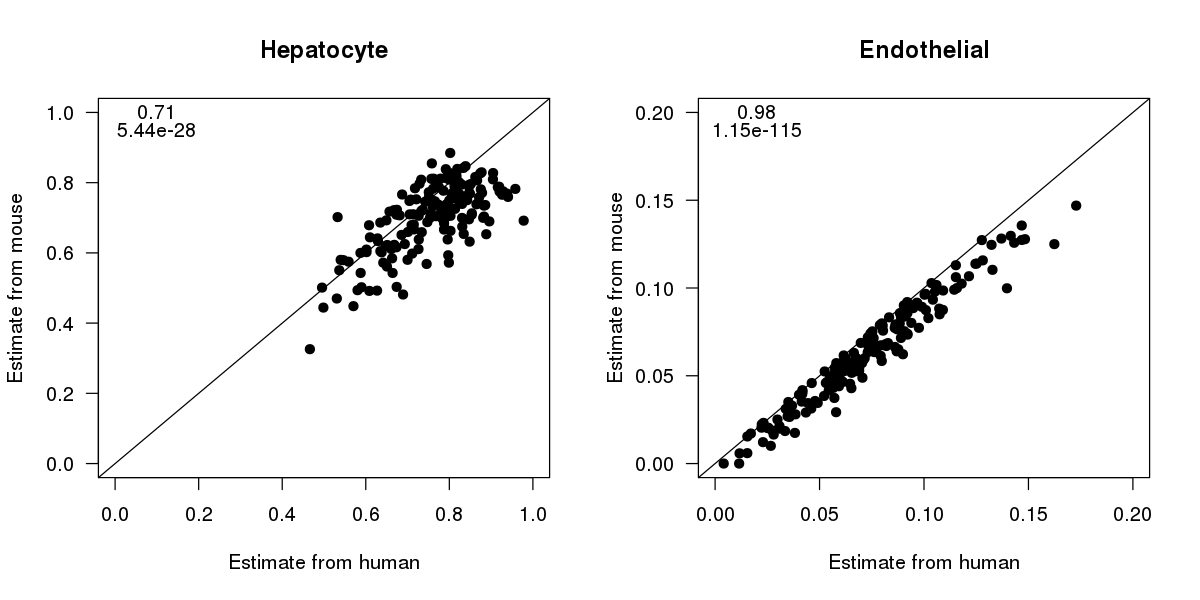

In [41]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1,2))
CorrPlotFrazer(liver_human$Hepatocytes0, liver_mouse$hepatocyte, 1, "Hepatocyte")
CorrPlotFrazer(liver_human$endothelial , liver_mouse$endothelial_cell_of_hepatic_sinusoid, .2, "Endothelial")

# Cor heatmap

In [43]:
cCells = read.table("../tables/merging_scheme_human_liver.txt", sep = "\t", header = T)

In [44]:
liver_human.wCollapsed <- liver_human[, !colnames(liver_human) %in% c("P.value", "Pearson.Correlation", "RMSE")]

for(i in seq(1, length(cCells$new_celltype))){
    
    x = c(str_split_fixed(cCells$merged_celltypes[i], ", ", 10))
    x = x[x != ""]    
    
    if(length(x) > 1){
        
        if(length(x[x %in% "central_venous_sinusoidal_endothelial_cells"]) != 1){
            liver_human.wCollapsed[paste("collapsed_", cCells$new_celltype[i], sep = "")] <- rowSums(liver_human.wCollapsed[, x])            
        
        }   
    }
}

In [45]:
CorSpeciesFrazer <- function(human, mouse){
    
    heart_human <- human
    heart_mouse <- mouse 
    
    heart_human.cor = heart_human #[, seq(1:(ncol(heart_human) - 3))]
    rownames(heart_human.cor) <- heart_human.cor$Input.Sample
    heart_human.cor$Input.Sample <- NULL
    colnames(heart_human.cor) <- paste(colnames(heart_human.cor), "human", sep = "_")
    
    heart_mouse.cor = heart_mouse #[, seq(1:(ncol(heart_mouse) - 3))]
    rownames(heart_mouse.cor) <- heart_mouse.cor$Input.Sample
    heart_mouse.cor$Input.Sample <- NULL
    colnames(heart_mouse.cor) <- paste(colnames(heart_mouse.cor), "mouse", sep = "_")
    
    m <- cbind(heart_human.cor, heart_mouse.cor)
    
    
#     m$endocardial_cell_mouse <- NULL
    m$Hepatocytes1_human <- NULL
    
    
    return(m)
}

In [60]:
HeatmapSpeciesFrazer <- function(human, mouse){
    
    m = CorSpeciesFrazer(human, mouse)
    res1 <- cor.mtest(m)
    m <- cor(m)

    rownames(res1$p) <- rownames(m)
    colnames(res1$p) <- colnames(m)

    m <- m[  grep("mouse", rownames(m)),]
    m <- m[, grep("human", colnames(m)) ]
    res1$p <- res1$p[  grep("mouse", rownames(res1$p)),]
    res1$p <- res1$p[, grep("human", colnames(res1$p)) ]
    
    rownames(m) = str_split_fixed(rownames(m), "_mouse", 2)[,1]
    colnames(m) = str_split_fixed(colnames(m), "_human", 2)[,1]

    
    rownames(m) = gsub("_", " ", rownames(m))
    colnames(m) = gsub("_", " ", colnames(m))
    
    
    corrplot(m, method = "color", cl.ratio = 0.5, p.mat = res1$p, sig.level = c(10e-100, 10e-25, 10e-15), pch.cex = 0.75, insig = "label_sig", pch.col = "white")#,
#              col = rev(colorRampPalette(c("#67001F", "#B2182B", "#D6604D", "#F4A582",
#                               "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE",
#                               "#4393C3", "#2166AC", "#053061"))(200)))
    
    
}

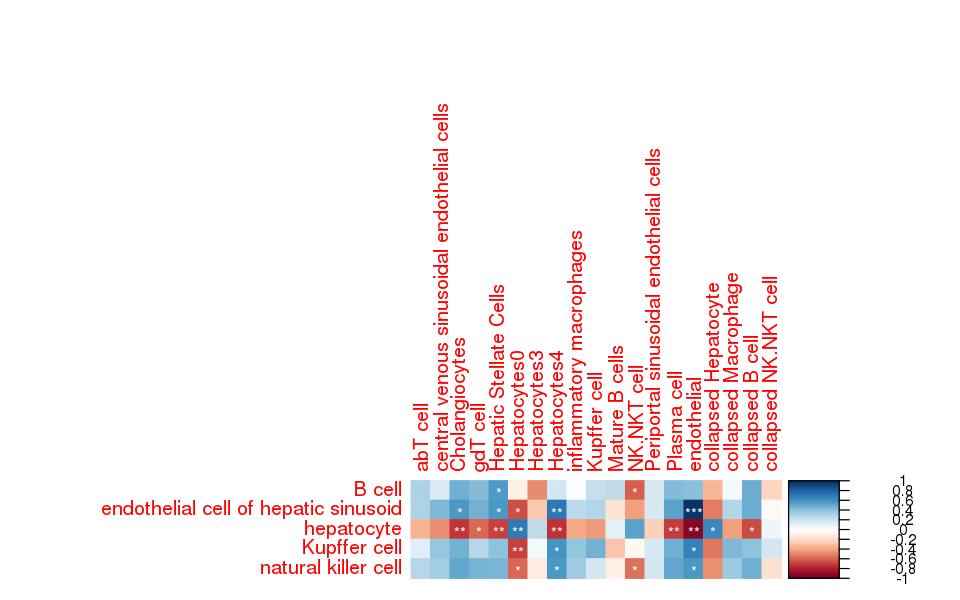

In [61]:
options(repr.plot.width = 8, repr.plot.height = 5)
HeatmapSpeciesFrazer(liver_human.wCollapsed[, !colnames(liver_human.wCollapsed) %in% c("P.value", "Pearson.Correlation", "RMSE")], liver_mouse[, !colnames(liver_mouse) %in% c("P.value", "Pearson.Correlation", "RMSE")])
